In [4]:
import sys
sys.path.append('../')
from Extractor import WaterExtractor
import mdtraj as md
import pickle
from utils_carl import get_mdfps
from scipy.stats import ks_2samp
import psycopg2
import pandas as pd
import psycopg2
from rdkit import Chem
from rdkit.Chem import AllChem
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'

cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()


Look at the relation between difference in starting conformer and difference in total potential energy in MD simulation

In [5]:
#make into df
import os
if not os.path.exists('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/distribution_stats/max_rmsds_confs.csv'):
    cur.execute('select * from conformers')
    conformers = cur.fetchall()
    df_confs = pd.DataFrame(conformers,columns= [desc[0] for desc in cur.description])
    #for each unique molregno, gert the molblocks, find maximum rmsd between mols. Save row: molregno, confid1, confid2, max_rmsd. We'll make a df from this
    molregnos = df_confs.molregno.unique()
    max_rmsds = []
    confid1s = []
    confid2s = []

    for molregno in molregnos:
        df_mol = df_confs[df_confs.molregno == molregno]
        molblocks = df_mol.molblock.values
        confids = df_mol.conf_id.values
        max_rmsd = 0
        for i in range(len(molblocks)):
            for j in range(i+1,len(molblocks)):
                mol1 = Chem.MolFromMolBlock(molblocks[i])
                mol2 = Chem.MolFromMolBlock(molblocks[j])
                rmsd = AllChem.GetBestRMS(mol1,mol2)
                if rmsd > max_rmsd:
                    max_rmsd = rmsd
                    confid1 = confids[i]
                    confid2 = confids[j]
        confid1s.append(confid1)
        confid2s.append(confid2)
        max_rmsds.append(max_rmsd)
        print(molregno,max_rmsd)

    df_max_rmsds = pd.DataFrame({'molregno':molregnos,'max_rmsd':max_rmsds,'confid1':confid1s,'confid2':confid2s})
    df_max_rmsds
    #drop zeros
    df_max_rmsds_nz = df_max_rmsds[df_max_rmsds.max_rmsd != 0]
    df_max_rmsds_nz.to_csv('max_rmsds_confs.csv')
else:
    df_max_rmsds_nz = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/distribution_stats/max_rmsds_confs.csv',index_col=0)

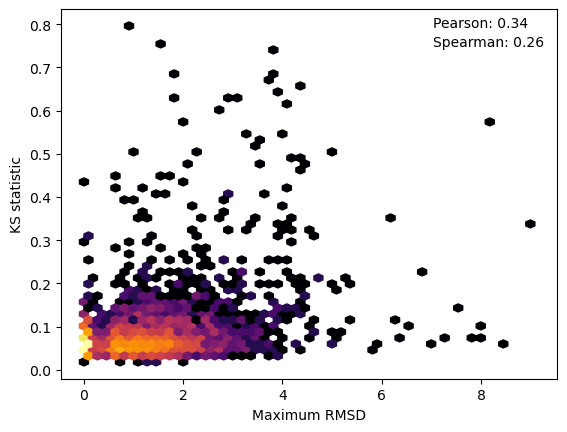

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr
df_ks_stats = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/distribution_stats/ks_stat.csv',index_col=0)
df_merged = df_ks_stats.merge(df_max_rmsds_nz,how='inner',on=['confid1','confid2'])
plt.hexbin(df_merged.max_rmsd,df_merged.ks_stat,gridsize=50,bins='log',cmap='inferno',mincnt=1)
plt.text(0.75,0.95,'Pearson: %.2f'%pearsonr(df_merged.max_rmsd,df_merged.ks_stat)[0],transform=plt.gca().transAxes)
plt.text(0.75,0.9,'Spearman: %.2f'%spearmanr(df_merged.max_rmsd,df_merged.ks_stat)[0],transform=plt.gca().transAxes)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic')
plt.show()



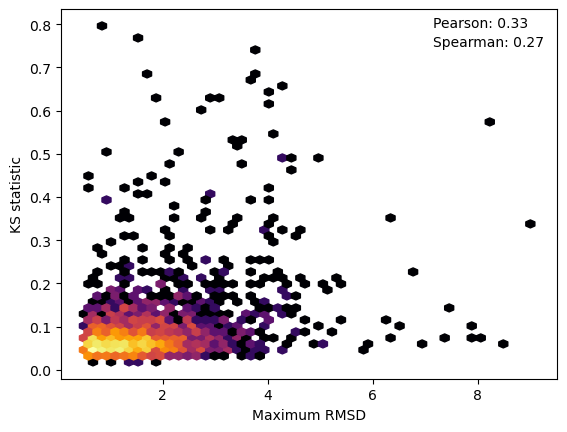

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr

df_ks_stats = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/distribution_stats/ks_stat.csv',index_col=0)
df_merged = df_ks_stats.merge(df_max_rmsds_nz,how='inner',on=['confid1','confid2'])
#get only rmsd > 0.5
df_merged_tmp = df_merged[df_merged.max_rmsd > 0.5]
plt.hexbin(df_merged_tmp.max_rmsd,df_merged_tmp.ks_stat,gridsize=50,bins='log',cmap='inferno',mincnt=1)
plt.text(0.75,0.95,'Pearson: %.2f'%pearsonr(df_merged_tmp.max_rmsd,df_merged_tmp.ks_stat)[0],transform=plt.gca().transAxes)
plt.text(0.75,0.9,'Spearman: %.2f'%spearmanr(df_merged_tmp.max_rmsd,df_merged_tmp.ks_stat)[0],transform=plt.gca().transAxes)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic')
plt.show()



There seems to be some correlation, but not super strong. Lets look at a few of the extremes:

In [38]:
import numpy as np
from rdkit.Chem import Draw
def check_dists(confid1,confid2,check = False):
    traj1 = md.load(f"example_data/{confid1}.h5")
    rdk_pmd1 = pickle.load(open(f"example_data/{confid1}.pickle", "rb"))

    energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
    water_total_ene1 = energie_dict1["water_total_ene"]


    traj2 = md.load(f"example_data/{confid2}.h5")
    rdk_pmd2 = pickle.load(open(f"example_data/{confid2}.pickle", "rb"))

    energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
    water_total_ene2 = energie_dict2["water_total_ene"]
    ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
    print(f'KS statistic: {np.round(ks_statistic,3)} pval: {np.round(p_value,5)}')
    print(f'Conf1 mean: {np.round(np.mean(water_total_ene1),3)} std: {np.round(np.std(water_total_ene1),3)}, Conf1 median: {np.round(np.median(water_total_ene1),3)}, datapoints: {len(water_total_ene1)}')
    print(f'Conf2 mean: {np.round(np.mean(water_total_ene2),3)} std: {np.round(np.std(water_total_ene2),3)}, Conf2 median: {np.round(np.median(water_total_ene2),3)}, datapoints: {len(water_total_ene2)}')

    if check:
        #get vals from df
        df_tmp = df_max_rmsds_nz[(df_max_rmsds_nz.confid1 == confid1) & (df_max_rmsds_nz.confid2 == confid2)]
        #get rmsd
        rmsd = df_tmp.max_rmsd.values[0]
        print('Recorded RMSD: ',rmsd)
        #get ks_stat
        df_tmp = df_ks_stats[(df_ks_stats.confid1 == confid1) & (df_ks_stats.confid2 == confid2)]
        ks_stat = df_tmp.ks_stat.values[0]
        print('Recorded KS statistic: ',ks_stat)

    plt.hist(water_total_ene1,bins=100,alpha=0.5,label='confid1')
    plt.hist(water_total_ene2,bins=100,alpha=0.5,label='confid2')
    #set axis titles
    plt.xlabel('Water total energy (kJ/mol)')
    plt.ylabel('Frequency')


    cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
    results = cur.fetchall()
    results
    mols = [Chem.MolFromMolBlock(result[3]) for result in results]
    print(f'RMSD: {AllChem.AlignMol(mols[0],mols[1])}')
    img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
    return img


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


KS statistic: 0.212 pval: 0.0
Conf1 mean: -66.717 std: 9.591, Conf1 median: -67.127, datapoints: 500
Conf2 mean: -70.61 std: 9.791, Conf2 median: -71.473, datapoints: 500
Recorded RMSD:  1.347750370602337
Recorded KS statistic:  0.212
RMSD: 1.347750370602337


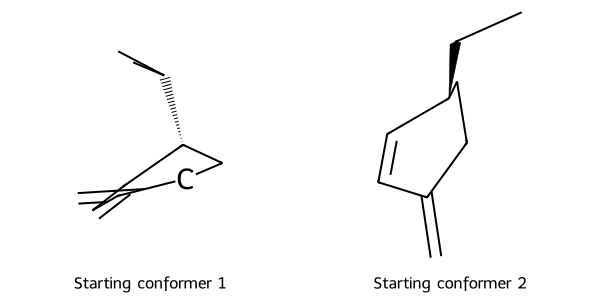

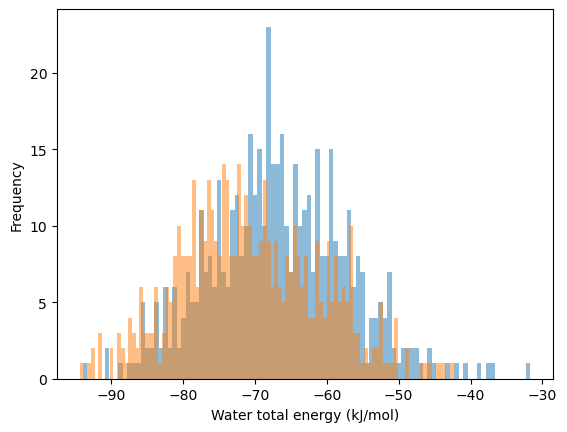

In [39]:
confid1 = 8195
confid2= 8197
img = check_dists(confid1,confid2,check=True)
img

KS statistic: 0.07 pval: 0.17256
Conf1 mean: -196.939 std: 19.245, Conf1 median: -197.248, datapoints: 500
Conf2 mean: -198.18 std: 18.662, Conf2 median: -199.767, datapoints: 500
RMSD: 8.168043362677533


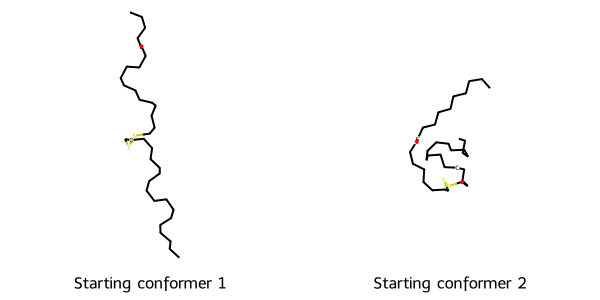

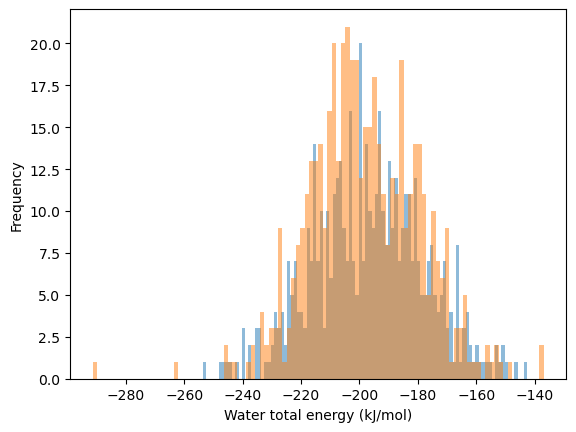

In [41]:
#example: very high rmsd, very low KS statistic
confid1 = 2361
confid2= 7712
img = check_dists(confid1,confid2)
img


KS statistic: 0.796 pval: 0.0
Conf1 mean: -2070.679 std: 77.542, Conf1 median: -2077.318, datapoints: 500
Conf2 mean: -1924.033 std: 41.768, Conf2 median: -1922.437, datapoints: 106
RMSD: 1.7201268713000086


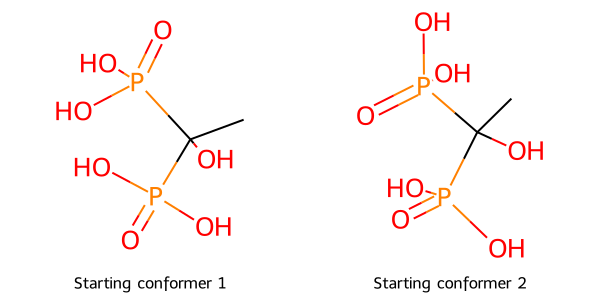

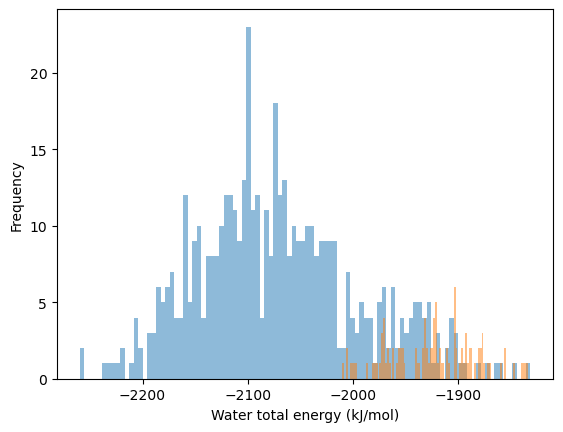

In [42]:
#example: very low rsmd, very high KS statistic
confid1 = 12383
confid2= 12384
img = check_dists(confid1,confid2)
img


Something went wrong here with the simulation!

KS statistic: 0.76 pval: 0.0
Conf1 mean: -267.402 std: 24.105, Conf1 median: -267.763, datapoints: 500
Conf2 mean: -219.728 std: 18.308, Conf2 median: -219.927, datapoints: 500
RMSD: 1.5251880011060217


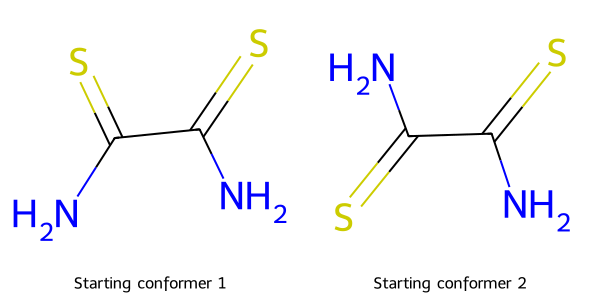

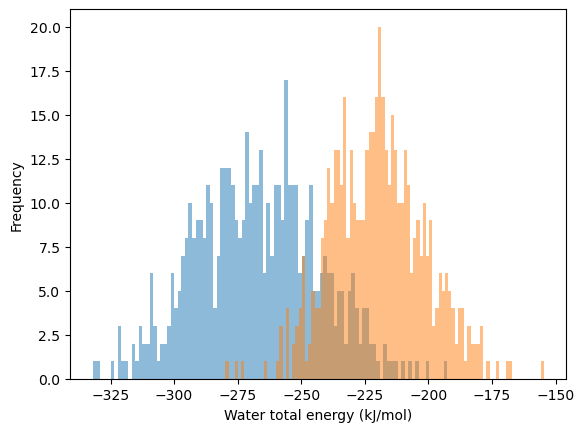

In [43]:
#example: low rmsd, high KS statistic
confid1 = 1955
confid2= 10891
img = check_dists(confid1,confid2)
img